In [286]:
from pandas import read_csv, DataFrame, concat
from datetime import datetime
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np 
import pandas as pd 



months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 
          'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,
         'November': 11, 'December': 12}

def encode(l):
    encoded = []
    for m in l:
        for key, value in months.items():
            if key == m:
                encoded.append(value)
    return encoded


def parse(x):
    return datetime.strptime(x, '%m/%d/%Y')

# Data Loading
data_set = pd.read_csv('march2020clean.csv', sep =',', date_parser = parse)
data_set = data_set.iloc[:data_set['totalSoybeanMealSupply'].last_valid_index(),:] # Truncate dataset to those where every data is available 
'''
'closePrice','openPrice','highPrice','lowPrice','totalSoybeanMealSupply','totalSoybeanMealDemand','soybeanOilSupply','soybeanOilDemand','sunflowerSeedPrice','canolaPrice','peanutsPrice','flaxseedPrice','soybeanOilPrice','cottonseedOilPrice','sunflowerseedOilPrice','canolaOilPrice','peanutOilPrice','cornOilPrice','soybeanMealPrice','cottonseedmealPrice','sunflowerseedMealPrice','linseedMealPrice'
'''
target_col = ['closePrice','totalSoybeanMealSupply','totalSoybeanMealDemand', 'Month']
data_set['Month'] = encode(data_set['Month'])
data_set = data_set.loc[:,target_col]
shift = 8

In [287]:
data_set
values = data_set.values
values = values.astype('float32')
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaler2 = MinMaxScaler()
scaled2 = scaler2.fit_transform(values[:,0].reshape(-1,1))


In [288]:
def series_to_supervised(data, seq_length, y_col):
    X = [] 
    Y = []
    for time in range(len(data)-seq_length):
        X += [data[time:time+seq_length]]
        Y += [data[time+seq_length][y_col]]
    
    return X,Y


data_x, data_y = scaled[:-shift], scaled[shift:]
separation = int(len(data_x)*0.8)
train_x, train_y = data_x[:separation], data_y[:separation]
test_x, test_y = data_x[separation:], data_y[separation:]
train_x = train_x.reshape(1, train_x.shape[0], train_x.shape[1])
train_y = train_y.reshape(1, train_y.shape[0], train_y.shape[1])
test_x = test_x.reshape(1, test_x.shape[0], test_x.shape[1])
test_y = test_y.reshape(1, test_y.shape[0], test_y.shape[1])
print(train_x.shape)
print(train_y.shape)

(1, 319, 4)
(1, 319, 4)


Epoch 1/3000
Epoch 2/3000
Epoch 3/3000
Epoch 4/3000
Epoch 5/3000
Epoch 6/3000
Epoch 7/3000
Epoch 8/3000
Epoch 9/3000
Epoch 10/3000
Epoch 11/3000
Epoch 12/3000
Epoch 13/3000
Epoch 14/3000
Epoch 15/3000
Epoch 16/3000
Epoch 17/3000
Epoch 18/3000
Epoch 19/3000
Epoch 20/3000
Epoch 21/3000
Epoch 22/3000
Epoch 23/3000
Epoch 24/3000
Epoch 25/3000
Epoch 26/3000
Epoch 27/3000
Epoch 28/3000
Epoch 29/3000
Epoch 30/3000
Epoch 31/3000
Epoch 32/3000
Epoch 33/3000
Epoch 34/3000
Epoch 35/3000
Epoch 36/3000
Epoch 37/3000
Epoch 38/3000
Epoch 39/3000
Epoch 40/3000
Epoch 41/3000
Epoch 42/3000
Epoch 43/3000
Epoch 44/3000
Epoch 45/3000
Epoch 46/3000
Epoch 47/3000
Epoch 48/3000
Epoch 49/3000
Epoch 50/3000
Epoch 51/3000
Epoch 52/3000
Epoch 53/3000
Epoch 54/3000
Epoch 55/3000
Epoch 56/3000
Epoch 57/3000
Epoch 58/3000
Epoch 59/3000
Epoch 60/3000
Epoch 61/3000
Epoch 62/3000
Epoch 63/3000
Epoch 64/3000
Epoch 65/3000
Epoch 66/3000
Epoch 67/3000
Epoch 68/3000
Epoch 69/3000
Epoch 70/3000
Epoch 71/3000
Epoch 72/3000
E

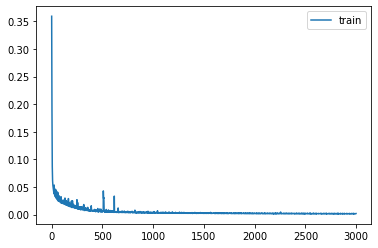

In [317]:
# design network
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """
    warmup_steps = 50
    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, stateful = False, input_shape = (None, train_x.shape[2])))
regressor.add(LSTM(units = 4, return_sequences = True, stateful = False))
regressor.compile(optimizer = RMSprop(lr=1e-3), loss = loss_mse_warmup)

history = regressor.fit(train_x, train_y, epochs = 3000, verbose=3)

# plot history
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# print(model.get_weights())

W1025 03:09:47.759420  4836 legend.py:1282] No handles with labels found to put in legend.


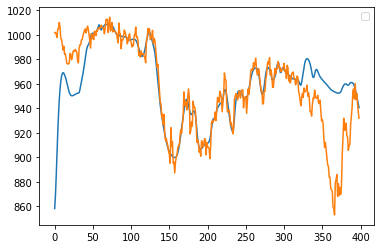

In [323]:
pyplot.figure()
#pyplot.plot(inv_y, label = 'Actual')
# pyplot.plot(y_hat, label = 'Forecast')
a = regressor.predict(data_x.reshape(1, data_x.shape[0], data_x.shape[1])) 
a = a.reshape(a.shape[1], a.shape[2])
a = scaler.inverse_transform(a)
b = data_y.reshape(1, data_x.shape[0], data_x.shape[1])
b = b.reshape(b.shape[1], b.shape[2])
b = scaler.inverse_transform(b)
pyplot.plot(a[:,0])
pyplot.plot(b[:,0])
#pyplot.plot(inv_yhat2, label = 'Forecast2')
pyplot.legend()
pyplot.show()

In [316]:
newModel = Sequential()
newModel.add(LSTM(units = 50, return_sequences = True, stateful = False, input_shape = (None, train_x.shape[2])))
newModel.add(LSTM(units = 4, return_sequences = False, stateful = False))

newModel.set_weights(regressor.get_weights())

lastSteps = np.empty((1,train_x.shape[1],train_x.shape[2])) #includes a shift at the beginning to cover the gap 
lastSteps[:,:shift] = train_x[:,-shift:] #the initial shift steps are filled with x training data 
newModel.predict(train_x[:,:-shift,:]).reshape(1,1,train_x.shape[2]) #just to adjust states, predict with x without the last shift elements




array([[[0.71479166, 0.3316919 , 0.4917556 , 0.10398153]]], dtype=float32)

In [311]:
totalLength = 400
rangeLen = totalLength-train_x.shape[1]-shift
print('rangeLen: ', rangeLen)
for i in range(rangeLen):
    lastSteps[:,i+shift] = newModel.predict(lastSteps[:,i:i+1,:]).reshape(1,1,train_x.shape[2])
print(lastSteps.shape)
forecastFromSelf = lastSteps[:,shift:,:]
print(forecastFromSelf.shape)

y_hat = scaler.inverse_transform(forecastFromSelf.reshape((forecastFromSelf.shape[1],forecastFromSelf.shape[2])))[:,0]


rangeLen:  73
(1, 319, 4)
(1, 311, 4)


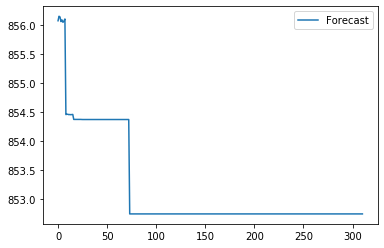

In [312]:
pyplot.figure()
#pyplot.plot(inv_y, label = 'Actual')
# pyplot.plot(y_hat, label = 'Forecast')
pyplot.plot(y_hat, label='Forecast')
#pyplot.plot(inv_yhat2, label = 'Forecast2')
pyplot.legend()
pyplot.show()

In [301]:
forecast_distance = 300

x_given = test_x

x_hat = np.zeros((x_given.shape[1] + forecast_distance, x_given.shape[2]))
print(x_hat.shape)
x_hat[:x_given.shape[1],:] = x_given 
y_hat = np.zeros((x_given.shape[1] + forecast_distance))
print(x_hat.shape)
for i in range(shift, len(x_given)+forecast_distance):
    pred = regressor.predict(x_hat[i-shift:i,:].reshape(1,shift, x_given.shape[2]))
    if i >= x_given.shape[1]:
        x_hat[i,:] = pred 
    y_hat[i] = pred[0,0]
    #predictor.reset_states()

y_hat = y_hat[shift:]
    
#yhat2 = regressor.predict(test_x)[:,0]

# invert scaling for forecast
inv_yhat = scaler2.inverse_transform(y_hat.reshape(-1,1))
# invert scaling for forecast
#inv_yhat2 = scaler2.inverse_transform(yhat2.reshape(-1,1))
# invert scaling for actual
#inv_y = scaler2.inverse_transform(np.concatenate((train_y[:,0],test_y[:,0]), axis=0).reshape(-1,1))


pyplot.figure()
#pyplot.plot(inv_y, label = 'Actual')
pyplot.plot(inv_yhat, label = 'Forecast')
#pyplot.plot(inv_yhat2, label = 'Forecast2')
pyplot.legend()
pyplot.show()

(380, 4)
(380, 4)


ValueError: setting an array element with a sequence.